In [1]:
# Imports
import os
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf


from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

2023-02-03 13:52:16.140998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 13:52:17.854247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2023-02-03 13:52:17.854404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2023-02-03 13:52:17.854414: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
# Using GPU on local machine, comment this enrire code block out if you are using CPU

# Uncomment block to confirm Tensoflow is actually using GPU
'''
# Confirm Tensorflow is using GPU
 tf.debugging.set_log_device_placement(True)
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)
'''


# Avoid OOM errors by limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU
Physical devices cannot be modified after being initialized


2023-02-03 13:52:26.065394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 13:52:26.310036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 13:52:26.310702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 13:52:26.313553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [3]:
# Check for available GPUs
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Directory paths to use
TRAIN_IMG_PATH = '../data/train/'
TEST_IMG_PATH = '../data/test/'
TRAIN_ANNOTATION_PATH = '../data/train.csv'
TEST_PREDICTIONS_PATH = '../data/submission.csv'
MODEL_PATH = '../models/'
LOG_PATH = '../logs/'

In [5]:
# Read and preview annotation into data frame
df = pd.read_csv(TRAIN_ANNOTATION_PATH)
print(f'Number of records: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.head()

Number of records: 18618
Number of columns: 2


,id,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,0
4,4.jpg,1


In [6]:
# Counts for each prediction class
df.value_counts('label')

label
1    10330
0     8288
dtype: int64

In [8]:
# Replace binary labels with strings
df.label.replace({0: 'Real', 1: 'AI_Generated'}, inplace=True)
df.head(20)

,id,label
0,0.jpg,AI_Generated
1,1.jpg,AI_Generated
2,2.jpg,AI_Generated
3,3.jpg,Real
4,4.jpg,AI_Generated
5,5.jpg,AI_Generated
6,6.jpg,AI_Generated
7,7.jpg,Real
8,8.jpg,AI_Generated
9,9.jpg,AI_Generated


In [9]:
# Let's reformat the directories so it works better with Tensorflow
# We want to have folders for each class and move the image files of each class into their respective folder

# Uncomment and only run this once
'''
# Create subfolders
labels = df.sort_values('label')
class_names = list(labels.label.unique())

for name in class_names:
    folder_name = TRAIN_IMG_PATH + name
    os.makedirs(folder_name)

# Move files to subfolders
for name in class_names:
    files = list(df[df['label']== name]['id'])
    for file in files:
        path_from = TRAIN_IMG_PATH + file
        path_to = TRAIN_IMG_PATH + name + '/' + file
        shutil.move(path_from, path_to)
'''

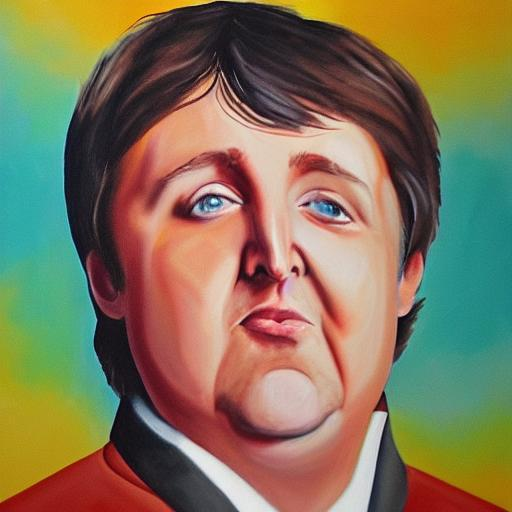

In [9]:
# Preview an AI generated image
images = os.listdir(TRAIN_IMG_PATH + 'AI_Generated/')
PIL.Image.open(TRAIN_IMG_PATH + 'AI_Generated/' + random.choice(images))

In [36]:
# Define some parameters for the Keras data loader and model
batch_size = 32
img_height = 180
img_width = 180
seed = 42
epochs = 25


In [11]:
# Preprocess image data located in directory with labels in separate .csv file and split into training, validation, and testing datasets

train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_IMG_PATH,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)
                                            
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_IMG_PATH,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)
                                   

Found 18618 files belonging to 2 classes.
Using 14895 files for training.
Found 18618 files belonging to 2 classes.
Using 3723 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['AI_Generated', 'Real']


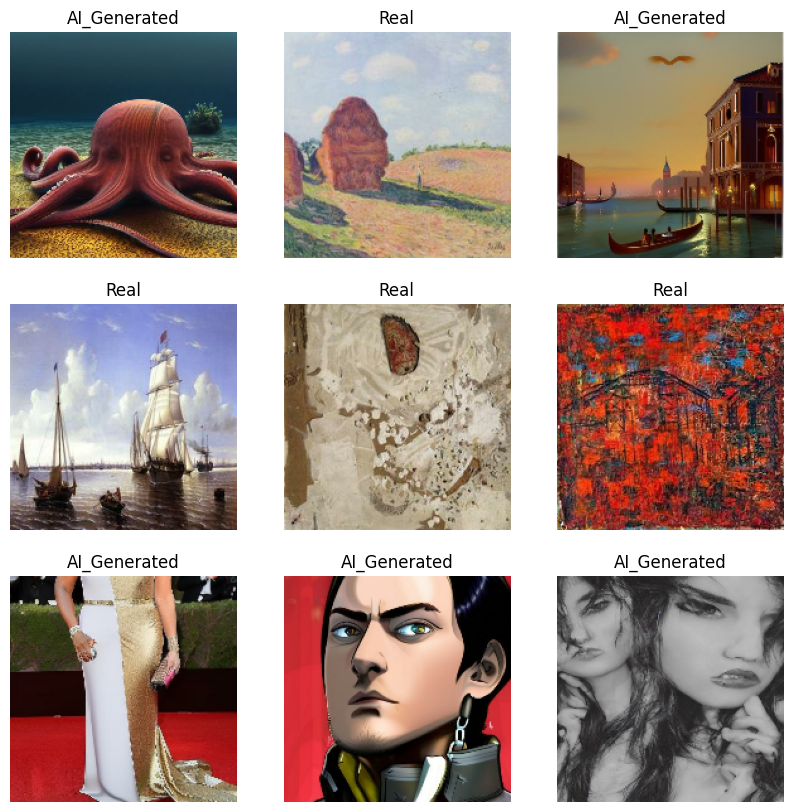

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [25]:
# Let's generate some additional training data with data augmentation features that Tensorflow provides to improve model performance and avoid overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

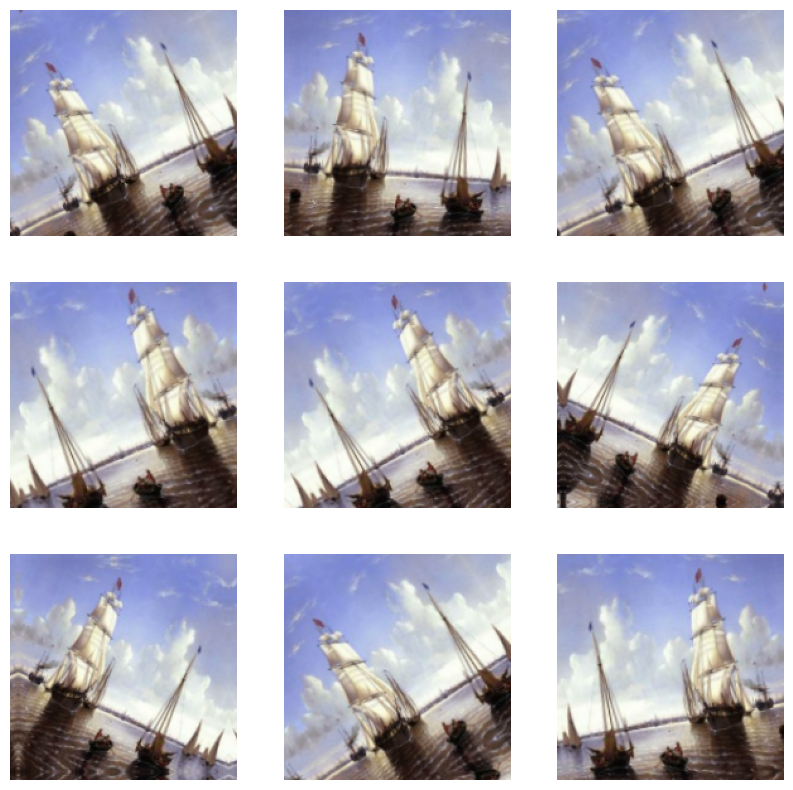

In [26]:
# Confirm and view data augmentation on a sampled image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [39]:
# Build model

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
# Initiate Tensorboard for logging during model training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH)

In [41]:
# View all layers of network
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [42]:
# Train Model

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/25


2023-02-03 16:22:10.819291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


466/466 [==============================] - 161s 333ms/step - loss: 0.5542 - accuracy: 0.7074 - val_loss: 0.5078 - val_accuracy: 0.7314
Epoch 2/25
466/466 [==============================] - 173s 372ms/step - loss: 0.4766 - accuracy: 0.7614 - val_loss: 0.4317 - val_accuracy: 0.7867
Epoch 3/25
466/466 [==============================] - 170s 366ms/step - loss: 0.4453 - accuracy: 0.7831 - val_loss: 0.4154 - val_accuracy: 0.7961
Epoch 4/25
466/466 [==============================] - 169s 363ms/step - loss: 0.4223 - accuracy: 0.8003 - val_loss: 0.3944 - val_accuracy: 0.8149
Epoch 5/25
466/466 [==============================] - 169s 363ms/step - loss: 0.4116 - accuracy: 0.8078 - val_loss: 0.3919 - val_accuracy: 0.8131
Epoch 6/25
466/466 [==============================] - 170s 364ms/step - loss: 0.3976 - accuracy: 0.8140 - val_loss: 0.3718 - val_accuracy: 0.8297
Epoch 7/25
466/466 [==============================] - 169s 363ms/step - loss: 0.3939 - accuracy: 0.8172 - val_loss: 0.3766 - val_accura

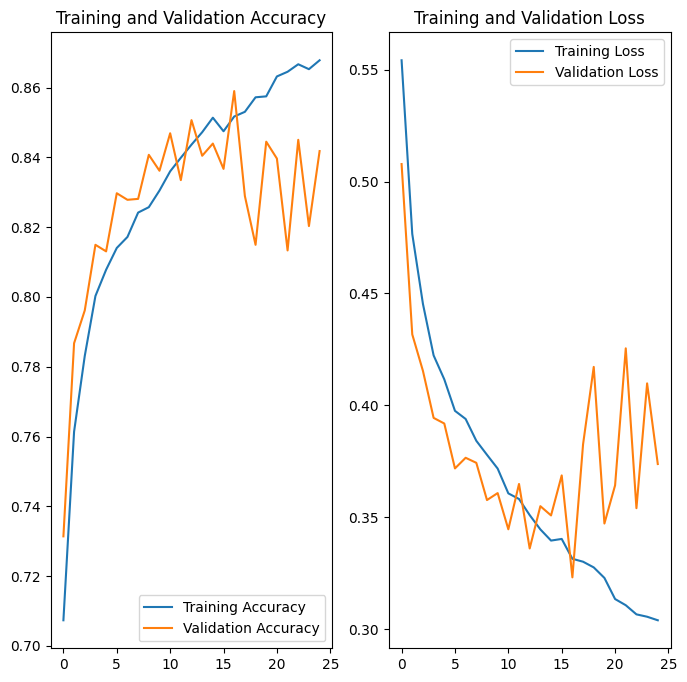

In [43]:
# Create plots of the loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

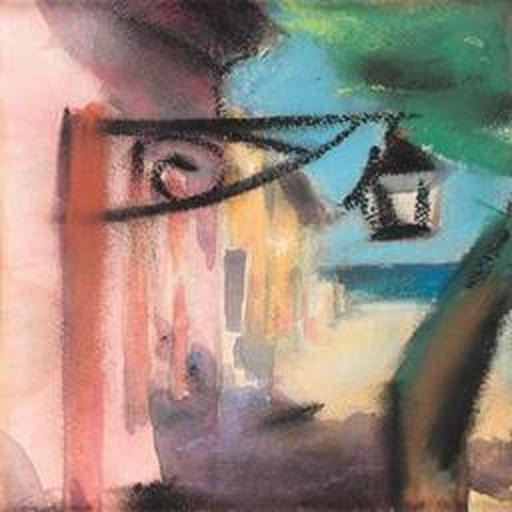

In [44]:
# Preview a test image before predictions
test_images = os.listdir(TEST_IMG_PATH)
test_image_path = TEST_IMG_PATH + random.choice(test_images)
PIL.Image.open(test_image_path)

In [45]:
# Predict on new data
def model_predict(model, img_path):
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

model_predict(model, test_image_path)

1/1 [==============================] - 0s 89ms/step
This image most likely belongs to Real with a 59.02 percent confidence.


In [46]:
# Save Model
from tensorflow.keras.models import load_model
from datetime import date

model.save(os.path.join(MODEL_PATH, 'tf_model_'+str(date.today())+'.h5'))

In [33]:
# Load saved model
loaded_model = load_model(MODEL_PATH + 'tf_model_20230129.h5')

### Let's do some transfer learning to see if leveraging a pretrained model yields better results!